In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def get_array(d):
#     while True:
    arr = np.random.randn(d,)
#         norm= np.linalg.norm(arr)
#         if norm <= 1:
    return list(arr/3)

In [3]:
def get_x(n,d):
    x=[]
    for _ in range(n):
        z=get_array(d)
        x.append(z)
    #print(x)
    x_mean=np.mean(x,axis=0)
    return x,x_mean
#x_mean list represents average of x in each client
#print(x_mean)

In [4]:
n=16
d=512
iters=20
x,x_mean= get_x(n,d)
#x_mean

In [5]:
def encoder(x,n,d,k):
    B=[]
    v=[]
    for i in range(n):
        u=x[i]
        x_min=np.min(u)
        x_max=np.max(u)
        s=x_max-x_min
        B_=np.linspace(x_min,x_max,num=k)
        v_=np.searchsorted(B_,u,side='right')-1   
        v.append(v_.tolist())
        B_client=np.append(B_,0)
        B.append(B_client.tolist())
        
    return B,v
            

In [6]:
def decoder(B,v,x,d):
    Y=[]
    sum1=0
    for i in range(n):
        u=x[i]
        x_max=np.max(u)
        x_min=np.min(u)
        y=[]
        for j in range(d):
            #B[j]=B(r)
            y_est=0
            r=v[i][j]
            z=B[i][r]
            w=B[i][r+1]
            p=(u[j]-z)/(w-z)
            sum1 +=(x_max-u[j])*(u[j]-x_min)                
            y_est=random.choices([w,z],[p,1-p])[0]
            y.append(y_est)   
        Y.append(y)
    return Y,sum1

In [7]:
def decoder_biased(B,v,x,d):
    Y=[]
    sum1=0
    for i in range(n):
        u=x[i]
        x_max=np.max(u)
        x_min=np.min(u)
        y=[]
        for j in range(d):
            #B[j]=B(r)
            y_est=0
            r=v[i][j]
            z=B[i][r]
            w=B[i][r+1]
            p=(u[j]-z)/(w-z) 
            l=(3*w+z)/4
            m=(3*z+w)/4
            y_est=random.choices([l,m],[p,1-p])[0]
            y.append(y_est)   
        Y.append(y)
    return Y

In [8]:
def loss_k(k1):
    loss=0
    sum2=0
    k=2**k1
    for _ in range(iters):
        
        sum_est_mean=0
        sum_est=0
        sum1 = 0
        B,v=encoder(x,n,d,k)
        #print(B,v)
        Y,sum1=decoder(B,v,x,d)
        sum2+=sum1
        x_mean_est=np.mean(Y,axis=0)
        error=np.subtract(x_mean_est,x_mean)
        loss+=(np.linalg.norm(error))**2
    return (loss/iters),(sum2/(iters*(n**2))),x_mean_est


In [9]:
def loss_k_biased(k1):
    loss_biased=0
    k=2**k1
    for _ in range(iters):
        Y_biased=[]
        sum_est_mean_biased=0
        sum_est_biased=0
        
        B,v=encoder(x,n,d,k)

        Y_biased=decoder_biased(B,v,x,d)

        x_mean_est_biased=np.mean(Y_biased,axis=0)
    
        error_biased=np.subtract(x_mean_est_biased,x_mean)
        loss_biased+=(np.linalg.norm(error_biased))**2
    return (loss_biased/iters)

In [28]:
losses=[]
losses_biased=[]
calc_losses=[]
theoretical_loss=0
calc_loss=0
#print(x_mean)
for k in range(1,7):
    #print(x)
    calc_loss,theoretical_loss,Y_mean=loss_k(k)
    #print(Y_mean)
    losses_biased.append(loss_k_biased(k))
    losses.append(calc_loss)
    calc_losses.append(theoretical_loss)
   

In [29]:
print(losses)
print(calc_losses)
print(losses_biased)

[29.898622709863645, 2.4613883816338507, 0.4571680684766267, 0.09804443999209667, 0.022818070651576528, 0.005608581658258621]
[29.63438561417985, 29.63438561417985, 29.63438561417985, 29.63438561417985, 29.63438561417985, 29.63438561417985]
[8.40537615253878, 0.9507699615700729, 0.18039246019685962, 0.04285640188582636, 0.013580370560657381, 0.006840566658032135]


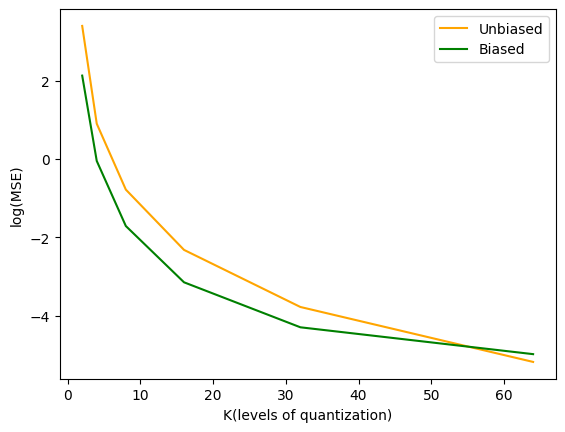

In [30]:
plt.plot(2**np.arange(1,7),np.log(losses),color="orange",label='Unbiased')
plt.plot(2**np.arange(1,7),np.log(losses_biased),color="g",label='Biased')
plt.xlabel("K(levels of quantization)")
plt.ylabel("log(MSE)")
plt.legend()
plt.savefig("log(MSE)_Unbiased_vs_Biased.pdf")